In [28]:
import numpy as np
import pandas as pd

# perceptron based predictor
class PerceptronBranchPredictor:
    def __init__(self, history_length=32, num_perceptrons=256):
        self.history_length = history_length
        self.num_perceptrons = num_perceptrons
        self.threshold = int(5 * self.history_length) 
        self.weights = np.zeros((num_perceptrons, history_length + 1))
        self.history = np.zeros(history_length)
    
    def predict(self, branch_address):
        index = int(branch_address) % self.num_perceptrons  
        perceptron = self.weights[index]
        y = perceptron[0] + np.dot(perceptron[1:], self.history)
        return 1 if y >= 0 else -1, y, index
    
    def train(self, branch_address, actual_outcome):
        prediction, y, index = self.predict(branch_address)
        if prediction != actual_outcome or abs(y) <= self.threshold:
            self.weights[index][0] += 1*actual_outcome
            self.weights[index][1:] += 1*actual_outcome * self.history
        self.history = np.roll(self.history, -1)
        self.history[-1] = actual_outcome

# Load dataset
data = pd.read_csv("example_trace_float.csv")


test_data = data

print(data.head(10))

# Ensure PC values are integers
data["PC"] = data["PC"].astype(int)

# Initialize predictor
predictor = PerceptronBranchPredictor()

# Test predictor
correct_predictions = 0
total_predictions = len(test_data)

for _, row in test_data.iterrows():
    branch_address = row["PC"]
    actual_outcome = 1 if row["resolveDir"] == 1 else -1
    
    prediction, _, _ = predictor.predict(branch_address)
    predictor.train(branch_address, actual_outcome)
    if prediction == actual_outcome:
        correct_predictions += 1

accuracy = (correct_predictions / total_predictions) * 100
print(f"Test Prediction Accuracy: {accuracy:.2f}%")


   seq_no  piece          PC  resolveDir
0      21      0  2147484444           0
1     122      0  2147484960           0
2     199      0     4199612           1
3     181      0     4199556           0
4     210      0     4203664           0
5     235      0     4203732           1
6     239      0     4204092           0
7     251      0     4204140           1
8     245      0     4204116           0
9     249      0     4204132           0
Test Prediction Accuracy: 96.16%


In [29]:
import pandas as pd
import numpy as np

#logistic regression based predictor
class MultiLogisticBranchPredictor:
    def __init__(self, num_classifiers=256, history_length=32, learning_rate=0.1):
        self.num_classifiers = num_classifiers
        self.history_length = history_length
        self.lr = learning_rate

        # One weight vector and bias per classifier
        self.weights = np.zeros((num_classifiers, history_length))
        self.biases = np.zeros(num_classifiers)

        # Global branch history (shared across classifiers)
        self.history = np.zeros(history_length)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, branch_address):
        index = branch_address % self.num_classifiers
        w = self.weights[index]
        b = self.biases[index]
        z = np.dot(w, self.history) + b
        prob = self.sigmoid(z)
        return 1 if prob >= 0.5 else -1, prob, index

    def train(self, branch_address, actual_outcome):
        prediction, prob, index = self.predict(branch_address)
        y = 1 if actual_outcome == 1 else 0
        gradient = prob - y
        self.weights[index] -= self.lr * gradient * self.history
        self.biases[index] -= self.lr * gradient

        # Update global history
        self.history = np.roll(self.history, -1)
        self.history[-1] = actual_outcome


In [30]:
# Load dataset
data = pd.read_csv("example_trace_float.csv")
data["PC"] = data["PC"].astype(int)
data["Outcome"] = data["resolveDir"].apply(lambda x: 1 if x == 1 else -1)
# data.dtypes
# Initialize predictor
predictor = MultiLogisticBranchPredictor(learning_rate=0.1)

correct_predictions = 0
total_predictions = 0

for _, row in data.iterrows():
    branch_address = row["PC"]
    actual_outcome = 1 if row["resolveDir"] == 1 else -1
    
    prediction,_,_= predictor.predict(branch_address)
    predictor.train(branch_address, actual_outcome)
    # print(prediction,actual_outcome)
    if prediction == actual_outcome:
        correct_predictions += 1
    total_predictions += 1

accuracy = (correct_predictions / total_predictions) * 100
print(f"Multi-Logistic Branch Predictor Accuracy: {accuracy:.2f}%")


Multi-Logistic Branch Predictor Accuracy: 95.81%


In [3]:
import numpy as np

#neural network based predictor
class MultiTinyNNBranchPredictor:
    def __init__(self, num_predictors=256, history_length=32, hidden_size=16, learning_rate=0.01):
        self.num_predictors = num_predictors
        self.history_length = history_length
        self.hidden_size = hidden_size
        self.lr = learning_rate

        # Each NN has its own weights and biases
        self.W1 = np.random.randn(num_predictors, hidden_size, history_length) * 0.01
        self.b1 = np.zeros((num_predictors, hidden_size))
        self.W2 = np.random.randn(num_predictors, hidden_size) * 0.01
        self.b2 = np.zeros(num_predictors)

        # Shared global history
        self.history = np.zeros(history_length)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def tanh(self, x):
        return np.tanh(x)

    def _index(self, branch_address):
        return hash(str(branch_address)) % self.num_predictors

    def predict(self, branch_address):
        idx = self._index(branch_address)

        z1 = self.W1[idx] @ self.history + self.b1[idx]
        a1 = self.tanh(z1)
        z2 = self.W2[idx] @ a1 + self.b2[idx]
        prob = self.sigmoid(z2)

        self._cache = (idx, self.history.copy(), z1, a1, prob)
        return 1 if prob >= 0.5 else -1

    def train(self, branch_address, actual_outcome):
        idx, x, z1, a1, prob = self._cache
        y = 1 if actual_outcome == 1 else 0
        error = prob - y

        dW2 = error * a1
        db2 = error

        dz1 = error * self.W2[idx] * (1 - np.tanh(z1)**2)
        dW1 = np.outer(dz1, x)
        db1 = dz1

        self.W2[idx] -= self.lr * dW2
        self.b2[idx] -= self.lr * db2
        self.W1[idx] -= self.lr * dW1
        self.b1[idx] -= self.lr * db1

        # Update global history
        self.history = np.roll(self.history, -1)
        self.history[-1] = actual_outcome


In [4]:
# Load and preprocess

import pandas as pd
data = pd.read_csv("example_trace_float.csv")
data["PC"] = data["PC"].astype(int)
data["Outcome"] = data["resolveDir"].apply(lambda x: 1 if x == 1 else -1)

# Initialize predictor
predictor = MultiTinyNNBranchPredictor(learning_rate=0.05)

correct_predictions = 0

total_predictions = 0

# Loop
for _, row in data.iterrows():
    branch_address = row["PC"]
    actual_outcome = 1 if row["resolveDir"] == 1 else -1

    prediction = predictor.predict(branch_address)
    predictor.train(branch_address, actual_outcome)

    if prediction == actual_outcome:
        correct_predictions += 1
    total_predictions += 1

accuracy = (correct_predictions / total_predictions) * 100
print(f"TinyNN Branch Predictor Accuracy: {accuracy:.2f}%")

TinyNN Branch Predictor Accuracy: 97.53%


In [2]:
import numpy as np
import pandas as pd

class OneBitBranchPredictor:
    def __init__(self, num_entries=256):
        self.num_entries = num_entries
        self.prediction_table = np.zeros(num_entries, dtype=int)  # 1-bit predictor (0=not taken, 1=taken)
    
    def predict(self, branch_address):
        index = int(branch_address) % self.num_entries
        return self.prediction_table[index]
    
    def train(self, branch_address, actual_outcome):
        index = int(branch_address) % self.num_entries
        self.prediction_table[index] = actual_outcome

# Load dataset
data = pd.read_csv("example_trace_float.csv")

# Ensure PC values are integers
data["PC"] = data["PC"].astype(int)

# Initialize 1-bit predictor
predictor = OneBitBranchPredictor()

# Test predictor
correct_predictions = 0
total_predictions = len(data)

for _, row in data.iterrows():
    branch_address = row["PC"]
    actual_outcome = 1 if row["resolveDir"] == 1 else 0
    
    prediction = predictor.predict(branch_address)
    predictor.train(branch_address, actual_outcome)
    if prediction == actual_outcome:
        correct_predictions += 1

accuracy = (correct_predictions / total_predictions) * 100
print(f"1-Bit Predictor Accuracy: {accuracy:.2f}%")

1-Bit Predictor Accuracy: 79.64%


In [5]:
import numpy as np
import pandas as pd

class TwoBitBranchPredictor:
    def __init__(self, num_entries=256):
        self.num_entries = num_entries
        self.prediction_table = np.ones(num_entries, dtype=int)  # 2-bit saturating counters (initialized to weakly taken)
    
    def predict(self, branch_address):
        index = int(branch_address) % self.num_entries
        return 1 if self.prediction_table[index] >= 2 else 0
    
    def train(self, branch_address, actual_outcome):
        index = int(branch_address) % self.num_entries
        if actual_outcome == 1:
            self.prediction_table[index] = min(3, self.prediction_table[index] + 1)
        else:
            self.prediction_table[index] = max(0, self.prediction_table[index] - 1)

# Load dataset
data = pd.read_csv("example_trace_float.csv")

# Ensure PC values are integers
data["PC"] = data["PC"].astype(int)

# Initialize 2-bit predictor
predictor = TwoBitBranchPredictor()

# Test predictor
correct_predictions = 0
total_predictions = len(data)

for _, row in data.iterrows():
    branch_address = row["PC"]
    actual_outcome = 1 if row["resolveDir"] == 1 else 0
    
    prediction = predictor.predict(branch_address)
    predictor.train(branch_address, actual_outcome)
    if prediction == actual_outcome:
        correct_predictions += 1

accuracy = (correct_predictions / total_predictions) * 100
print(f"2-Bit Predictor Accuracy: {accuracy:.2f}%")

2-Bit Predictor Accuracy: 89.23%


In [35]:
# HYBRID TEST : mixed two bit and perceptron
# import numpy as np
# import pandas as pd

# class TwoBitBranchPredictor:
#     def __init__(self, num_entries=512):
#         self.num_entries = num_entries
#         self.prediction_table = np.ones(num_entries, dtype=int)  # 2-bit saturating counters (initialized to weakly taken)
    
#     def predict(self, branch_address):
#         index = int(branch_address) % self.num_entries
#         return 1 if self.prediction_table[index] >= 2 else -1
    
#     def train(self, branch_address, actual_outcome):
#         index = int(branch_address) % self.num_entries
#         if actual_outcome == 1:
#             self.prediction_table[index] = min(3, self.prediction_table[index] + 1)
#         else:
#             self.prediction_table[index] = max(0, self.prediction_table[index] - 1)

# class PerceptronBranchPredictor:
#     def __init__(self, history_length=32, num_perceptrons=512):
#         self.history_length = history_length
#         self.num_perceptrons = num_perceptrons
#         self.threshold = int(3.5 * self.history_length) 
#         self.weights = np.zeros((num_perceptrons, history_length + 1))
#         self.history = np.zeros(history_length)
#         self.perceptron_usage = np.zeros(num_perceptrons, dtype=int)  # Count of how many times each perceptron is used
    
#     def predict(self, branch_address):
#         index = int(branch_address) % self.num_perceptrons  
#         perceptron = self.weights[index]
#         y = perceptron[0] + np.dot(perceptron[1:], self.history)
#         return 1 if y >= 0 else -1, y, index
    
#     def train(self, branch_address, actual_outcome):
#         _, y, index = self.predict(branch_address)
#         self.perceptron_usage[index] += 1  # Track how many times this perceptron is used
#         if abs(y) <= self.threshold:
#             self.weights[index][0] += 1 * actual_outcome
#             self.weights[index][1:] += 1* actual_outcome * self.history
#         self.history = np.roll(self.history, -1)
#         self.history[-1] = actual_outcome

# # Load dataset
# data = pd.read_csv("example.csv")

# # Split data into training (first 50,000) and testing (next 1,000)
# # train_data = data[:50000]
# test_data = data[:120100]

# # Ensure PC values are integers
# data["PC"] = data["PC"].astype(int)

# # Initialize predictors
# perceptron_predictor = PerceptronBranchPredictor()
# two_bit_predictor = TwoBitBranchPredictor()

# # Train predictor
# # for _, row in train_data.iterrows():
# #     branch_address = row["PC"]
# #     actual_outcome = 1 if row["resolveDir"] == 1 else -1
    
# #     index = int(branch_address) % perceptron_predictor.num_perceptrons
# #     if perceptron_predictor.perceptron_usage[index] < perceptron_predictor.history_length:
# #         two_bit_predictor.train(branch_address, actual_outcome)  # Use 2-bit predictor initially
# #     perceptron_predictor.train(branch_address, actual_outcome)  # Train perceptron in parallel

# # Test predictor
# correct_predictions = 0
# total_predictions = len(test_data)

# for _, row in test_data.iterrows():
#     branch_address = row["PC"]
#     actual_outcome = 1 if row["resolveDir"] == 1 else -1
    
#     index = int(branch_address) % perceptron_predictor.num_perceptrons
#     if perceptron_predictor.perceptron_usage[index] < perceptron_predictor.history_length:
#         prediction = two_bit_predictor.predict(branch_address)  # Use 2-bit predictor
#     else:
#         prediction, _, _ = perceptron_predictor.predict(branch_address)  # Use perceptron predictor
#     two_bit_predictor.train(branch_address, actual_outcome)  # Use 2-bit predictor initially
#     perceptron_predictor.train(branch_address, actual_outcome)
#     if prediction == actual_outcome:
#         correct_predictions += 1

# accuracy = (correct_predictions / total_predictions) * 100
# print(f"Hybrid Predictor Accuracy: {accuracy:.2f}%")


Evaluating predictors across different history lengths...


100%|██████████| 10/10 [03:03<00:00, 18.33s/it]


   History Length  Perceptron  Multi-Logistic  Multi-TinyNN
0               8   86.636917       85.843002     91.169144
1              12   89.302705       89.112568     92.654534
2              16   90.708936       90.637538     93.549338
3              20   91.391099       91.572698     94.250126
4              24   92.205968       92.600986     94.678515
5              28   92.465174       93.008420     94.984285
6              32   92.797330       93.371619     95.303248
7              36   92.962632       93.858989     95.573319
8              40   93.190796       94.159326     95.836405
9              44   93.436033       94.442591     96.016453


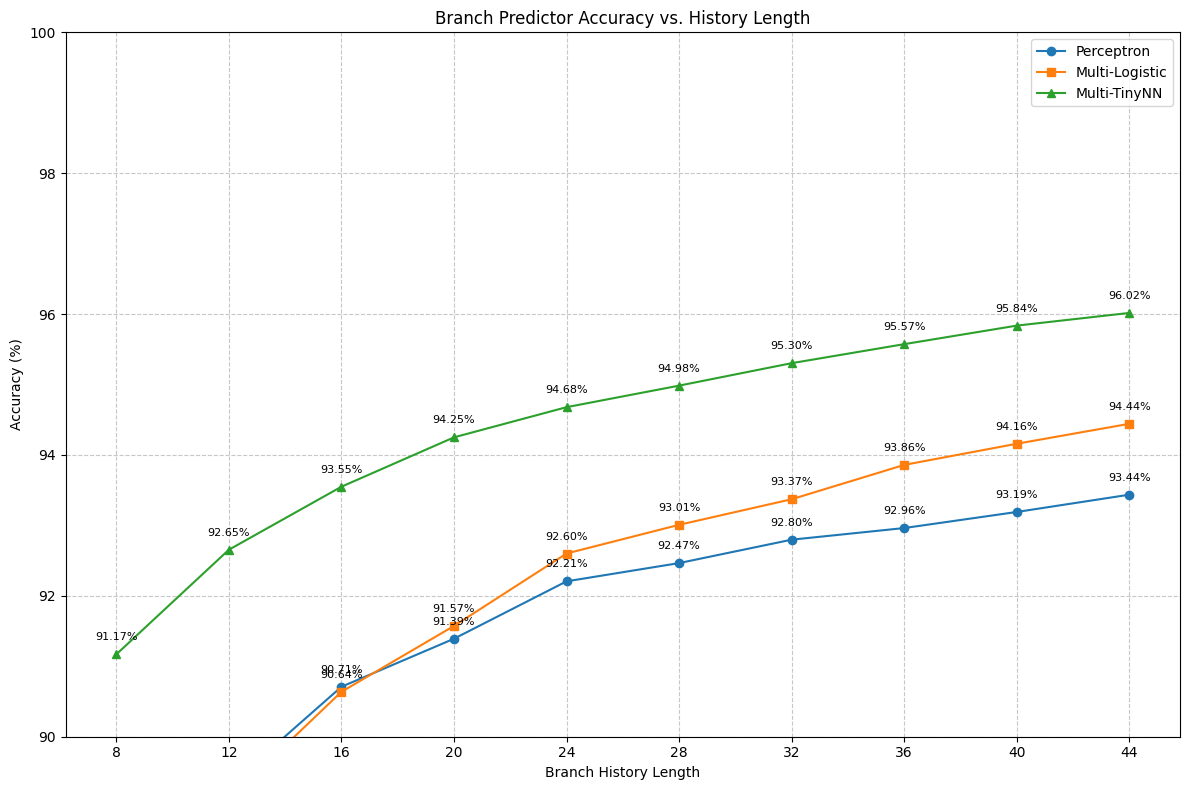

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

# Import the three branch predictor classes
# (Assuming they are defined as shown in your input)
# PerceptronBranchPredictor, MultiLogisticBranchPredictor, and MultiTinyNNBranchPredictor classes...

def evaluate_predictor(predictor_class, data, history_length, **kwargs):
    """Evaluate a branch predictor with given history length on the provided data."""
    # Initialize predictor with the specified history length
    predictor = predictor_class(history_length=history_length, **kwargs)
    
    correct_predictions = 0
    total_predictions = len(data)
    
    for _, row in data.iterrows():
        branch_address = row["PC"]
        actual_outcome = 1 if row["resolveDir"] == 1 else -1
        
        # Handle different predict method signatures
        if predictor_class.__name__ == "PerceptronBranchPredictor":
            prediction, _, _ = predictor.predict(branch_address)
        elif predictor_class.__name__ == "MultiLogisticBranchPredictor":
            prediction, _, _ = predictor.predict(branch_address)
        else:  # MultiTinyNNBranchPredictor
            prediction = predictor.predict(branch_address)
        
        predictor.train(branch_address, actual_outcome)
        if prediction == actual_outcome:
            correct_predictions += 1
    
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

# Load dataset
data = pd.read_csv("example_trace_int.csv")
data["PC"] = data["PC"].astype(int)

# Define history lengths to test
history_lengths = range(8, 45, 4)

# Dictionary to store results
results = {
    "History Length": list(history_lengths),
    "Perceptron": [],
    "Multi-Logistic": [],
    "Multi-TinyNN": []
}

# Evaluate each predictor across different history lengths
print("Evaluating predictors across different history lengths...")
for history_length in tqdm(history_lengths):
    # Perceptron predictor
    perceptron_accuracy = evaluate_predictor(
        PerceptronBranchPredictor, 
        data, 
        history_length,
        num_perceptrons=128
    )
    results["Perceptron"].append(perceptron_accuracy)
    
    # Multi-Logistic predictor
    logistic_accuracy = evaluate_predictor(
        MultiLogisticBranchPredictor, 
        data, 
        history_length,
        num_classifiers=128,
        learning_rate=0.1
    )
    results["Multi-Logistic"].append(logistic_accuracy)
    
    # Multi-TinyNN predictor
    nn_accuracy = evaluate_predictor(
        MultiTinyNNBranchPredictor, 
        data, 
        history_length,
        num_predictors=128,
        hidden_size=16,
        learning_rate=0.01
    )
    results["Multi-TinyNN"].append(nn_accuracy)

# Create DataFrame for results
results_df = pd.DataFrame(results)
print(results_df)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(results["History Length"], results["Perceptron"], marker='o', label="Perceptron")
plt.plot(results["History Length"], results["Multi-Logistic"], marker='s', label="Multi-Logistic")
plt.plot(results["History Length"], results["Multi-TinyNN"], marker='^', label="Multi-TinyNN")

plt.xlabel("Branch History Length")
plt.ylabel("Accuracy (%)")
plt.title("Branch Predictor Accuracy vs. History Length")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Set y-axis range from 70% to 100%
plt.ylim(90, 100)

# Add value annotations
for i, history_length in enumerate(results["History Length"]):
    for predictor in ["Perceptron", "Multi-Logistic", "Multi-TinyNN"]:
        plt.annotate(f'{results[predictor][i]:.2f}%', 
                     (history_length, results[predictor][i]),
                     textcoords="offset points",
                     xytext=(0,10), 
                     ha='center',
                     fontsize=8)

plt.xticks(results["History Length"])
plt.tight_layout()
plt.savefig("branch_predictor_comparison.png", dpi=300)
plt.show()

# Save results to CSV
results_df.to_csv("branch_predictor_results.csv", index=False)


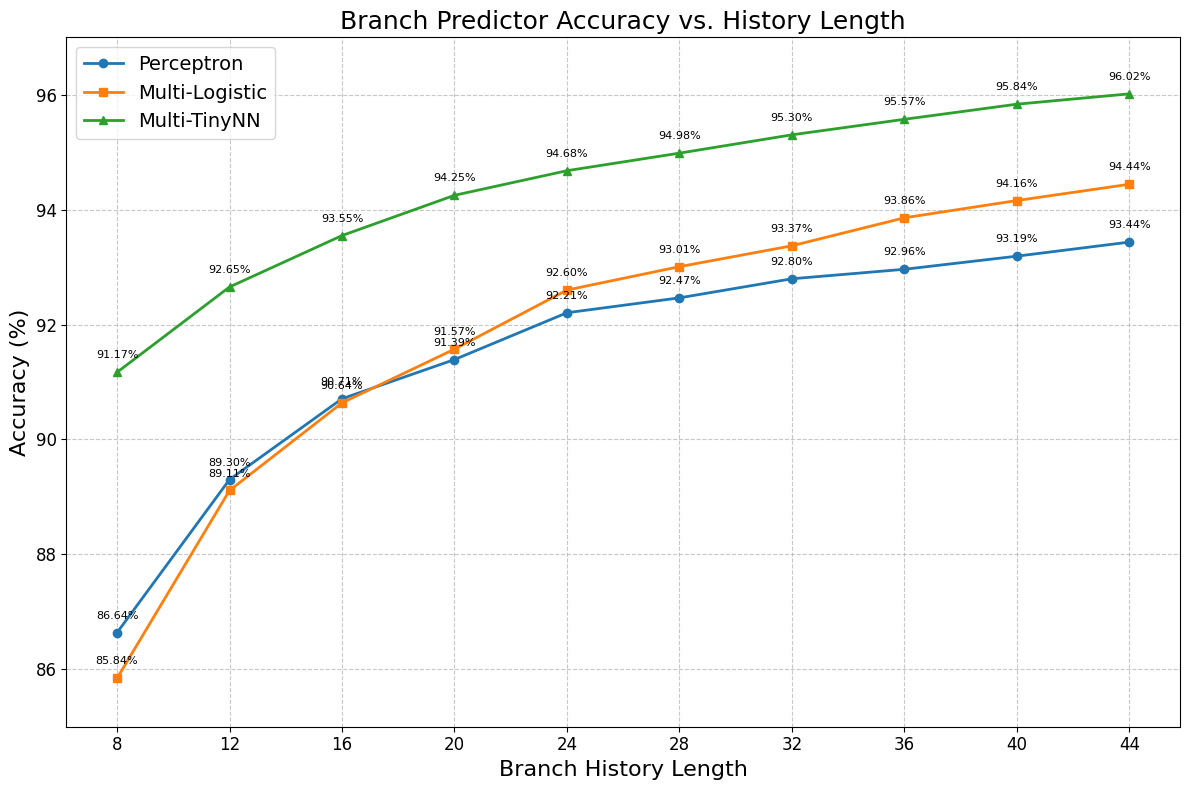

In [55]:

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(results["History Length"], results["Perceptron"], marker='o', label="Perceptron",linewidth=2)
plt.plot(results["History Length"], results["Multi-Logistic"], marker='s', label="Multi-Logistic",linewidth=2)
plt.plot(results["History Length"], results["Multi-TinyNN"], marker='^', label="Multi-TinyNN",linewidth=2)

plt.xlabel("Branch History Length",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=16)
plt.title("Branch Predictor Accuracy vs. History Length",fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=14)

# Set y-axis range from 70% to 100%
plt.ylim(85, 97)

# Add value annotations
for i, history_length in enumerate(results["History Length"]):
    for predictor in ["Perceptron", "Multi-Logistic", "Multi-TinyNN"]:
        plt.annotate(f'{results[predictor][i]:.2f}%', 
                     (history_length, results[predictor][i]),
                     textcoords="offset points",
                     xytext=(0,10), 
                     ha='center',
                     fontsize=8)

plt.xticks(results["History Length"],fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("branch_predictor_comparison.png", dpi=300)
plt.show()

# Save results to CSV
results_df.to_csv("branch_predictor_results.csv", index=False)


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

# Import the three branch predictor classes
# (Assuming they are defined as shown in your input)
# PerceptronBranchPredictor, MultiLogisticBranchPredictor, and MultiTinyNNBranchPredictor classes...

def evaluate_predictor(predictor_class, data, num_predictors, **kwargs):
    """Evaluate a branch predictor with given number of predictors on the provided data."""
    # Initialize predictor with fixed history length (32) and specified number of predictors
    if predictor_class.__name__ == "PerceptronBranchPredictor":
        predictor = predictor_class(num_perceptrons=num_predictors, **kwargs)
    elif predictor_class.__name__ == "MultiLogisticBranchPredictor":
        predictor = predictor_class(num_classifiers=num_predictors, **kwargs)
    else:  # MultiTinyNNBranchPredictor
        predictor = predictor_class(num_predictors=num_predictors, **kwargs)
    
    correct_predictions = 0
    total_predictions = len(data)
    
    for _, row in data.iterrows():
        branch_address = row["PC"]
        actual_outcome = 1 if row["resolveDir"] == 1 else -1
        
        # Handle different predict method signatures
        if predictor_class.__name__ == "PerceptronBranchPredictor":
            prediction, _, _ = predictor.predict(branch_address)
        elif predictor_class.__name__ == "MultiLogisticBranchPredictor":
            prediction, _, _ = predictor.predict(branch_address)
        else:  # MultiTinyNNBranchPredictor
            prediction = predictor.predict(branch_address)
        
        predictor.train(branch_address, actual_outcome)
        if prediction == actual_outcome:
            correct_predictions += 1
    
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

# Load dataset
data = pd.read_csv("example_trace_int.csv")
data["PC"] = data["PC"].astype(int)

# Fixed history length
history_length = 32

# Number of predictors to test (doubling each time from 128 to 2048)
num_predictors_list = [128, 256, 512, 1024, 2048]

# Dictionary to store results
results = {
    "Number of Predictors": num_predictors_list,
    "Perceptron": [],
    "Multi-Logistic": [],
    "Multi-TinyNN": []
}

# Evaluate each predictor across different numbers of predictors
print("Evaluating predictors with different table sizes...")
for num_predictors in tqdm(num_predictors_list):
    # Perceptron predictor
    perceptron_accuracy = evaluate_predictor(
        PerceptronBranchPredictor, 
        data, 
        num_predictors,
        history_length=history_length
    )
    results["Perceptron"].append(perceptron_accuracy)
    
    # Multi-Logistic predictor
    logistic_accuracy = evaluate_predictor(
        MultiLogisticBranchPredictor, 
        data, 
        num_predictors,
        history_length=history_length,
        learning_rate=0.1
    )
    results["Multi-Logistic"].append(logistic_accuracy)
    
    # Multi-TinyNN predictor
    nn_accuracy = evaluate_predictor(
        MultiTinyNNBranchPredictor, 
        data, 
        num_predictors,
        history_length=history_length,
        hidden_size=16,
        learning_rate=0.01
    )
    results["Multi-TinyNN"].append(nn_accuracy)

# Create DataFrame for results
results_df = pd.DataFrame(results)
print(results_df)



Evaluating predictors with different table sizes...


100%|██████████| 5/5 [01:28<00:00, 17.69s/it]

   Number of Predictors  Perceptron  Multi-Logistic  Multi-TinyNN
0                   128   92.797330       93.371619     95.260564
1                   256   95.543052       96.711808     96.409142
2                   512   96.849948       97.962050     97.558496
3                  1024   98.031896       98.749757     98.410617
4                  2048   98.551085       99.078810     98.724147


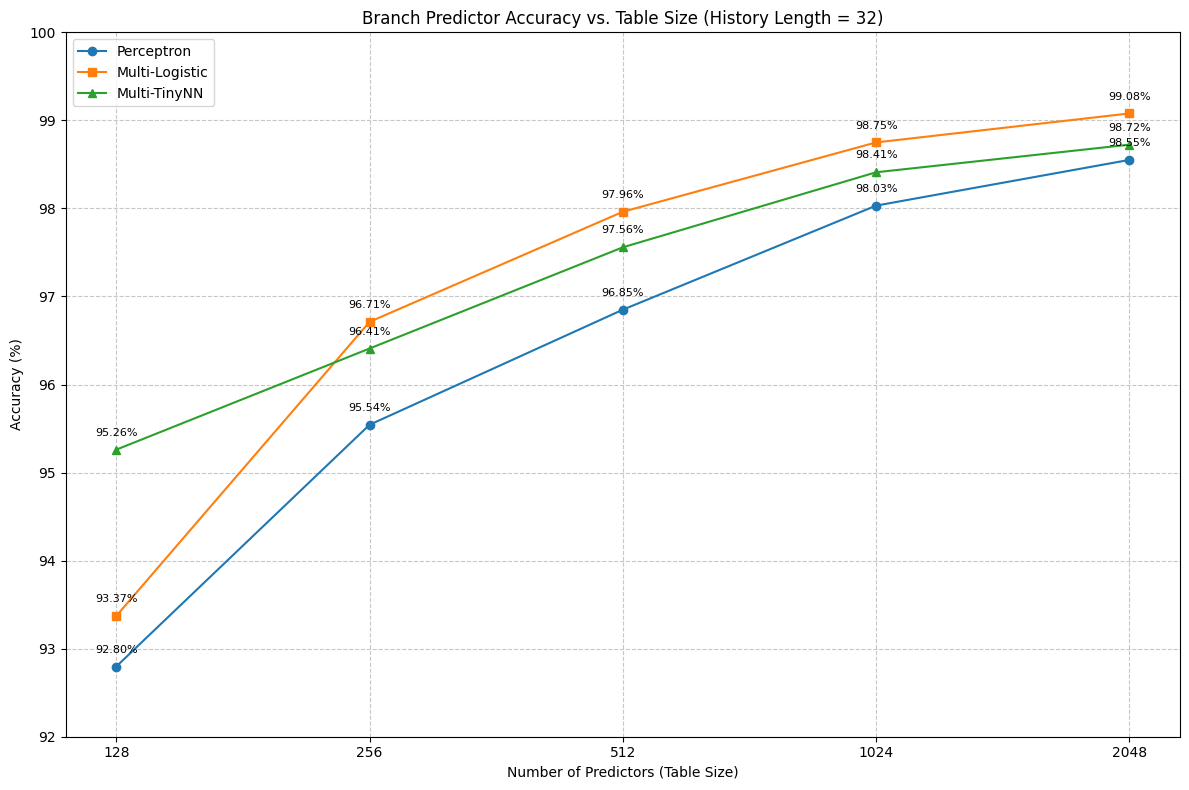

In [53]:
# Plot results
plt.figure(figsize=(12, 8))
plt.plot(results["Number of Predictors"], results["Perceptron"], marker='o', label="Perceptron")
plt.plot(results["Number of Predictors"], results["Multi-Logistic"], marker='s', label="Multi-Logistic")
plt.plot(results["Number of Predictors"], results["Multi-TinyNN"], marker='^', label="Multi-TinyNN")

plt.xlabel("Number of Predictors (Table Size)")
plt.ylabel("Accuracy (%)")
plt.title("Branch Predictor Accuracy vs. Table Size (History Length = 32)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Set y-axis range from 70% to 100%
plt.ylim(92, 100)

# Use logarithmic scale for x-axis since we're doubling each time
plt.xscale('log', base=2)
plt.xticks(num_predictors_list, [str(x) for x in num_predictors_list])

# Add value annotations
for i, num_predictors in enumerate(results["Number of Predictors"]):
    for predictor in ["Perceptron", "Multi-Logistic", "Multi-TinyNN"]:
        plt.annotate(f'{results[predictor][i]:.2f}%', 
                     (num_predictors, results[predictor][i]),
                     textcoords="offset points",
                     xytext=(0,10), 
                     ha='center',
                     fontsize=8)

plt.tight_layout()
plt.savefig("branch_predictor_table_size_comparison.png", dpi=300)
plt.show()

# Save results to CSV
results_df.to_csv("branch_predictor_table_size_results.csv", index=False)
